### In the notetbook, we attempt to train the model with xgboost and random forest

# 1. Import data and packages

In [1]:
# !pip uninstall scikit-learn imbalanced-learn -y

In [2]:
# !pip install scikit-learn
# !pip install imbalanced-learn

In [3]:
# pip install shap

In [8]:
# pip install tensorflow

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, confusion_matrix, auc, accuracy_score, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE, ADASYN

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
df = pd.read_csv('../database/2016-2022_median_imputation.csv')

In [3]:
df.head(3)

,year,ID,ticker,company_name,market_cap,bic_level_2,bic_level_3,unequal_voting,ceo_tenure,ipo_date,...,dividend_payout_ratio_industry_peers_percentile,dividend_payout_ratio_industry_peers_normalized,asset_to_equity_industry_peers_percentile,asset_to_equity_industry_peers_normalized,cash_conversion_cycle_industry_peers_percentile,cash_conversion_cycle_industry_peers_normalized,ev_ebitda_industry_peers_percentile,ev_ebitda_industry_peers_normalized,ev_ebit_industry_peers_percentile,ev_ebit_industry_peers_normalized
0,2016,1518855D US Equity,1518855D,Yahoo! Inc - Set up for Fundam,3.690000e+10,Media,Internet Media & Services,0.0,9.00000,NaN,...,50.000000,-0.242790,48.484848,-0.083976,50.000000,0.000000,15.151515,-0.475186,33.333333,0.110101
1,2016,1539941D UN Equity,1539941D,Spectra Energy LLC,2.880000e+10,Oil & Gas,Oil & Gas Producers,0.0,4.25000,NaN,...,100.000000,6.709610,80.263158,0.012658,51.162791,0.205408,74.358974,0.016097,89.743590,0.090888
2,2016,1556442D UA Equity,1556442D,GigPeak Inc,1.710000e+08,Tech Hardware & Semiconductors,Semiconductors,0.0,9.66667,NaN,...,37.313433,-0.372197,33.582090,-0.421308,84.375000,0.909061,67.164179,-0.099901,89.552239,0.272724


# 2. Retrieve necessary columns

We obtain the list of column names that will be used for model training. 

In [4]:
binary_variables = ["unequal_voting", "classified_board_system","poison_pill"]

non_ratio_variables = [
    'capex', 'capex_percentile', 'capex_10bins_percentile', 'capex_10bins_normalized', 'capex_div_market_cap', 'capex_div_log_market_cap', 
    'net_capex', 'net_capex_percentile', 'net_capex_10bins_percentile', 'net_capex_10bins_normalized', 'net_capex_div_market_cap', 'net_capex_div_log_market_cap', 
    'short_term_wc', 'short_term_wc_percentile', 'short_term_wc_10bins_percentile', 'short_term_wc_10bins_normalized', 'short_term_wc_div_market_cap', 'short_term_wc_div_log_market_cap', 
    'long_term_wc', 'long_term_wc_percentile', 'long_term_wc_10bins_percentile', 'long_term_wc_10bins_normalized', 'long_term_wc_div_market_cap', 'long_term_wc_div_log_market_cap', 
    'ebitda', 'ebitda_percentile', 'ebitda_10bins_percentile', 'ebitda_10bins_normalized', 'ebitda_div_market_cap', 'ebitda_div_log_market_cap', 
    'ebit', 'ebit_percentile', 'ebit_10bins_percentile', 'ebit_10bins_normalized', 'ebit_div_market_cap', 'ebit_div_log_market_cap', 
    'net_income', 'net_income_percentile', 'net_income_10bins_percentile', 'net_income_10bins_normalized', 'net_income_div_market_cap', 'net_income_div_log_market_cap', 
    'net_debt', 'net_debt_percentile', 'net_debt_10bins_percentile', 'net_debt_10bins_normalized', 'net_debt_div_market_cap', 'net_debt_div_log_market_cap', 
    'ev', 'ev_percentile', 'ev_10bins_percentile', 'ev_10bins_normalized', 'ev_div_market_cap', 'ev_div_log_market_cap', 
    'repurchase', 'repurchase_percentile', 'repurchase_10bins_percentile', 'repurchase_10bins_normalized', 'repurchase_div_market_cap', 'repurchase_div_log_market_cap', 
    'net_repurchase', 'net_repurchase_percentile', 'net_repurchase_10bins_percentile', 'net_repurchase_10bins_normalized', 'net_repurchase_div_market_cap', 'net_repurchase_div_log_market_cap', 
    'total_compensation_to_executives', 'total_compensation_to_executives_percentile', 'total_compensation_to_executives_10bins_percentile', 'total_compensation_to_executives_10bins_normalized', 'total_compensation_to_executives_div_market_cap', 'total_compensation_to_executives_div_log_market_cap', 
    'total_compensation_to_board_members', 'total_compensation_to_board_members_percentile', 'total_compensation_to_board_members_10bins_percentile', 'total_compensation_to_board_members_10bins_normalized', 'total_compensation_to_board_members_div_market_cap', 'total_compensation_to_board_members_div_log_market_cap'
]

ratio_variables = [
    'ebitda_margin', 'ebitda_margin_industry_peers_percentile', 'ebitda_margin_industry_peers_normalized', 
    'operating_margin', 'operating_margin_industry_peers_percentile', 'operating_margin_industry_peers_normalized', 
    'sales_to_total_assets', 'sales_to_total_assets_industry_peers_percentile', 'sales_to_total_assets_industry_peers_normalized', 
    'roe', 'roe_industry_peers_percentile', 'roe_industry_peers_normalized', 
    'normalized_roe', 'normalized_roe_industry_peers_percentile', 'normalized_roe_industry_peers_normalized', 
    'operating_roe', 'operating_roe_industry_peers_percentile', 'operating_roe_industry_peers_normalized', 
    'operating_roic', 'operating_roic_industry_peers_percentile', 'operating_roic_industry_peers_normalized', 
    'eps_adjusted_diluted', 'eps_adjusted_diluted_industry_peers_percentile', 'eps_adjusted_diluted_industry_peers_normalized', 
    'ev_to_sales', 'ev_to_sales_industry_peers_percentile', 'ev_to_sales_industry_peers_normalized', 
    'tobin_q_ratio', 'tobin_q_ratio_industry_peers_percentile', 'tobin_q_ratio_industry_peers_normalized', 
    'pb_ratio', 'pb_ratio_industry_peers_percentile', 'pb_ratio_industry_peers_normalized', 
    'pe_ratio', 'pe_ratio_industry_peers_percentile', 'pe_ratio_industry_peers_normalized', 
    'fcf_to_equity', 'fcf_to_equity_industry_peers_percentile', 'fcf_to_equity_industry_peers_normalized', 
    'sales_growth_rate', 'sales_growth_rate_industry_peers_percentile', 'sales_growth_rate_industry_peers_normalized', 
    'dividend_per_share', 'dividend_per_share_industry_peers_percentile', 'dividend_per_share_industry_peers_normalized', 
    'dividend_payout_ratio', 'dividend_payout_ratio_industry_peers_percentile', 'dividend_payout_ratio_industry_peers_normalized', 
    'asset_to_equity', 'asset_to_equity_industry_peers_percentile', 'asset_to_equity_industry_peers_normalized', 
    'cash_conversion_cycle', 'cash_conversion_cycle_industry_peers_percentile', 'cash_conversion_cycle_industry_peers_normalized', 
    'ev_ebitda', 'ev_ebitda_industry_peers_percentile', 'ev_ebitda_industry_peers_normalized', 
    'ev_ebit', 'ev_ebit_industry_peers_percentile', 'ev_ebit_industry_peers_normalized'
]

technical_variables = [
    "free_float_percentage",
    "rsi_14d",
    "rsi_30d",
    "volatility_30d",
    "volatility_90d",
    "volatility_180d",
    "volume_30d_average_to_outstanding",
    "insider_shares_percentage",
    "institution_ownership_percentage",
    "ceo_tenure",
    "total_return_5y",
    "total_return_4y",
    "total_return_3y",
    "total_return_2y",
    "total_return_1y",
    "total_return_6m",
    "total_return_3m"
]


factors = binary_variables + non_ratio_variables + ratio_variables + technical_variables

# 3. Train the model

In [5]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()
    
def plot_roc_curve(y_true, y_pred, label=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    if label:
        plt.legend()


Epoch 1/10
330/330 [==============================] - 0s 749us/step - loss: 0.2088 - accuracy: 0.9532 - val_loss: 0.1063 - val_accuracy: 0.9780
Epoch 2/10
330/330 [==============================] - 0s 667us/step - loss: 0.1758 - accuracy: 0.9641 - val_loss: 0.1120 - val_accuracy: 0.9780
Epoch 3/10
330/330 [==============================] - 0s 616us/step - loss: 0.1675 - accuracy: 0.9643 - val_loss: 0.1075 - val_accuracy: 0.9780
Epoch 4/10
330/330 [==============================] - 0s 639us/step - loss: 0.1568 - accuracy: 0.9648 - val_loss: 0.1077 - val_accuracy: 0.9780
Epoch 5/10
330/330 [==============================] - 0s 623us/step - loss: 0.1531 - accuracy: 0.9649 - val_loss: 0.1086 - val_accuracy: 0.9780
Epoch 6/10
330/330 [==============================] - 0s 619us/step - loss: 0.1525 - accuracy: 0.9647 - val_loss: 0.1061 - val_accuracy: 0.9780
Epoch 7/10
330/330 [==============================] - 0s 614us/step - loss: 0.1458 - accuracy: 0.9650 - val_loss: 0.1076 - val_accuracy:

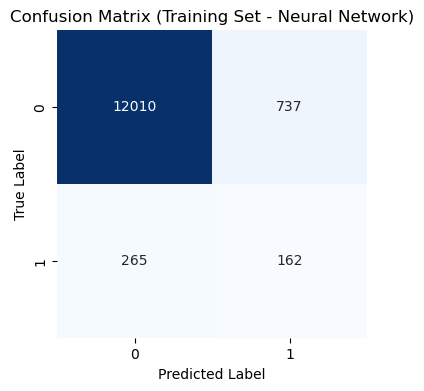

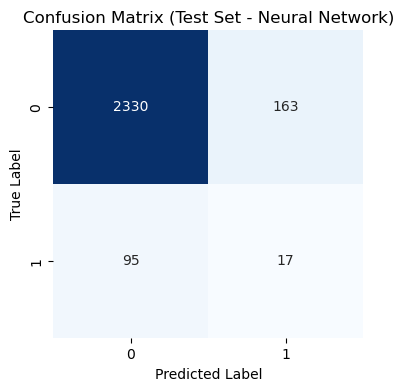

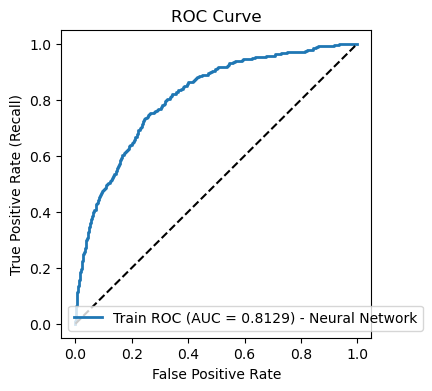

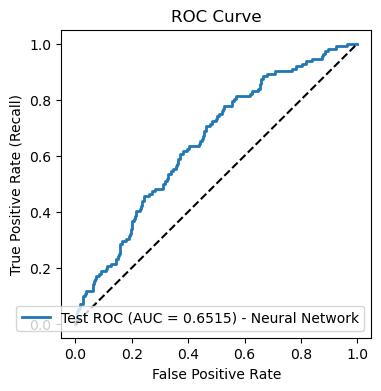

In [15]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score
from tensorflow import keras
from tensorflow.keras import layers

train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[factors]
y_train = train_data['targeted']

X_test = test_data[factors]
y_test = test_data['targeted']

# 1. Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Building the Neural Network
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. Training and Evaluation
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

y_pred_train_nn = model.predict(X_train_scaled)
y_pred_test_nn = model.predict(X_test_scaled)

cm_train_nn = confusion_matrix(y_train, y_pred_train_nn > 0.1)
cm_test_nn = confusion_matrix(y_test, y_pred_test_nn > 0.1)

plot_confusion_matrix(cm_train_nn, 'Confusion Matrix (Training Set - Neural Network)')
plot_confusion_matrix(cm_test_nn, 'Confusion Matrix (Test Set - Neural Network)')

auc_train_nn = roc_auc_score(y_train, y_pred_train_nn)
auc_test_nn = roc_auc_score(y_test, y_pred_test_nn)

plot_roc_curve(y_train, y_pred_train_nn, label=f"Train ROC (AUC = {auc_train_nn:.4f}) - Neural Network")
plot_roc_curve(y_test, y_pred_test_nn, label=f"Test ROC (AUC = {auc_test_nn:.4f}) - Neural Network")
plt.legend(loc="lower right")
plt.show()


## 3.1 Xgboost with all the columns without oversampling

In [14]:
train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[factors]
y_train = train_data['targeted']

X_test = test_data[factors]
y_test = test_data['targeted']

xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=14)

In [15]:
y_pred_train = cross_val_predict(xgboost_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = xgboost_model.predict_proba(X_test)[:, 1]

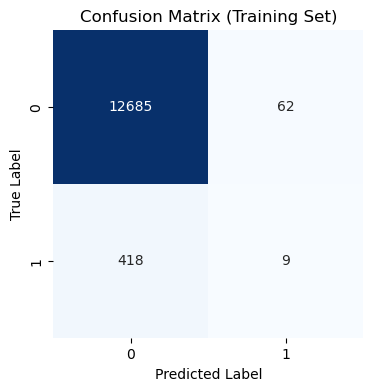

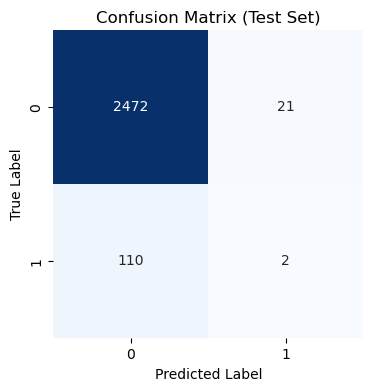

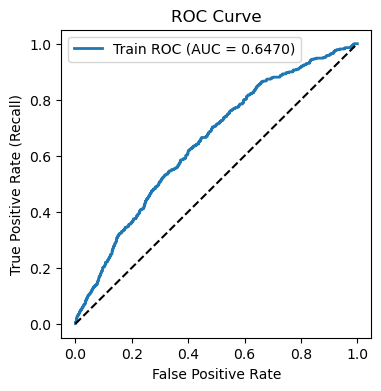

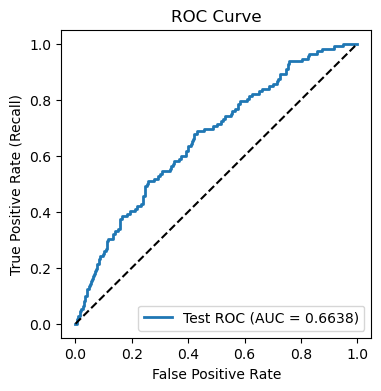

In [16]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.1)
cm_test = confusion_matrix(y_test, y_pred_test > 0.1)

plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


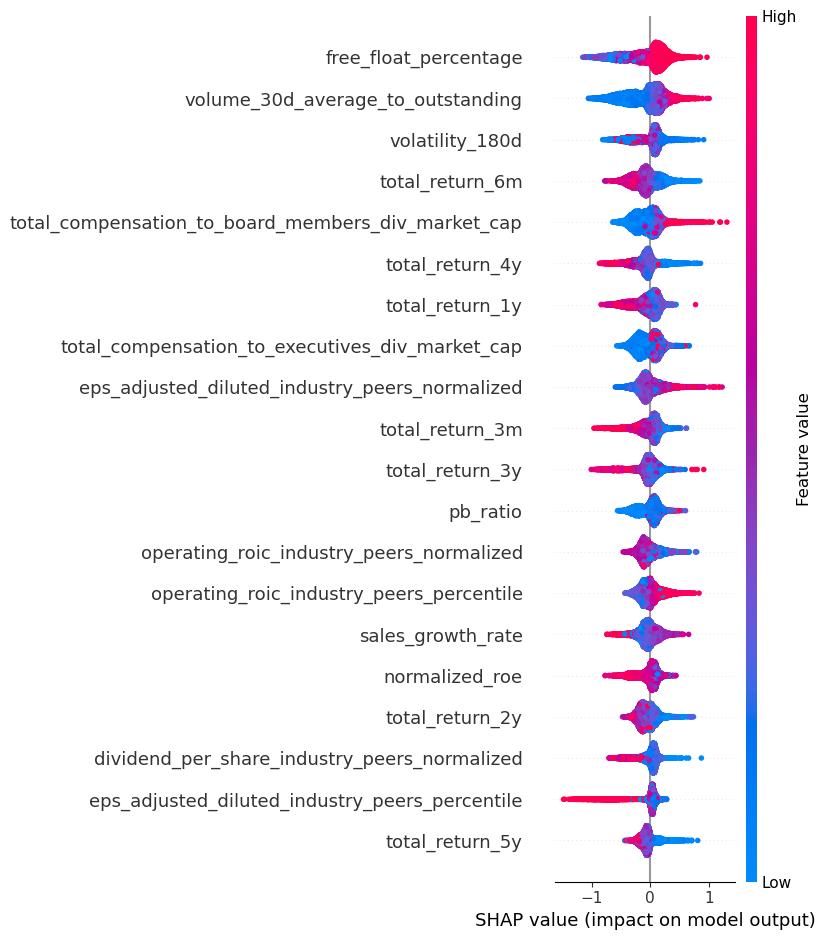

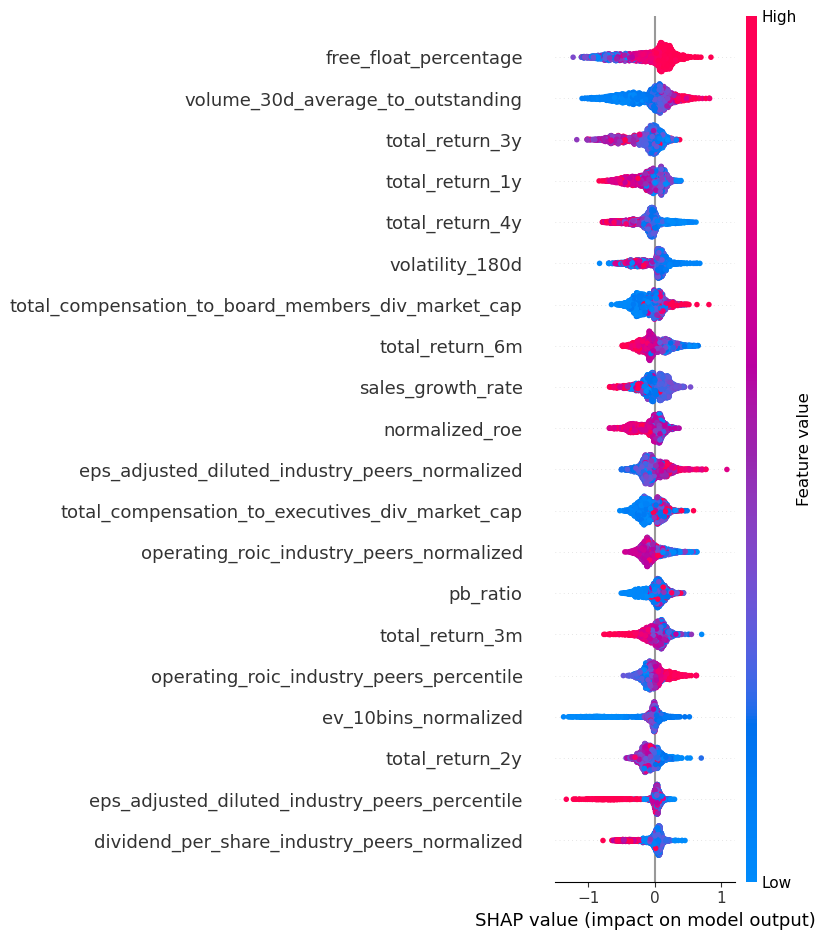

In [12]:
explainer = shap.Explainer(xgboost_model)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values_train, X_train)
shap.summary_plot(shap_values_test, X_test)

## 3.2. Random Forest with all the columns

In [13]:
# Splitting the data
train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[factors]
y_train = train_data['targeted']

X_test = test_data[factors]
y_test = test_data['targeted']

# Training the Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Cross-validation predictions for ROC curve
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
y_pred_train = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = clf.predict_proba(X_test)[:, 1]

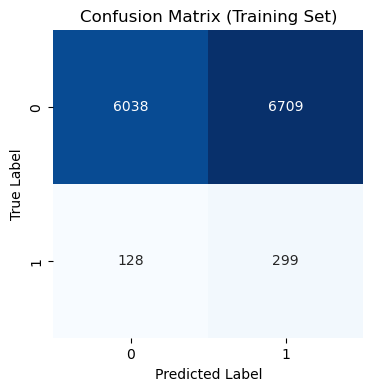

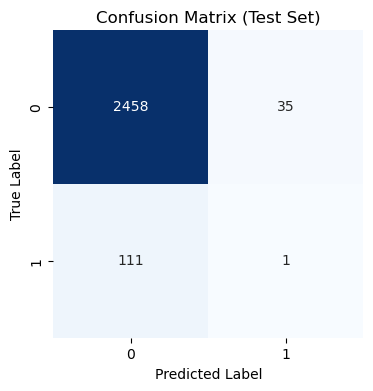

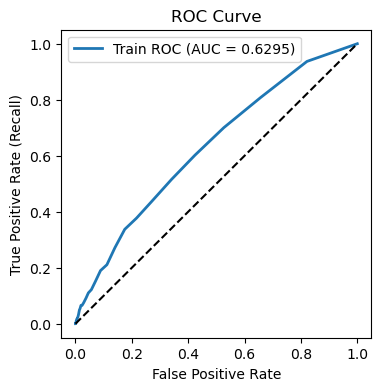

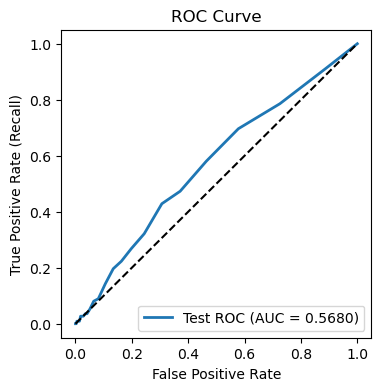

In [15]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.02)
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')

cm_test = confusion_matrix(y_test, y_pred_test > 0.19)
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()

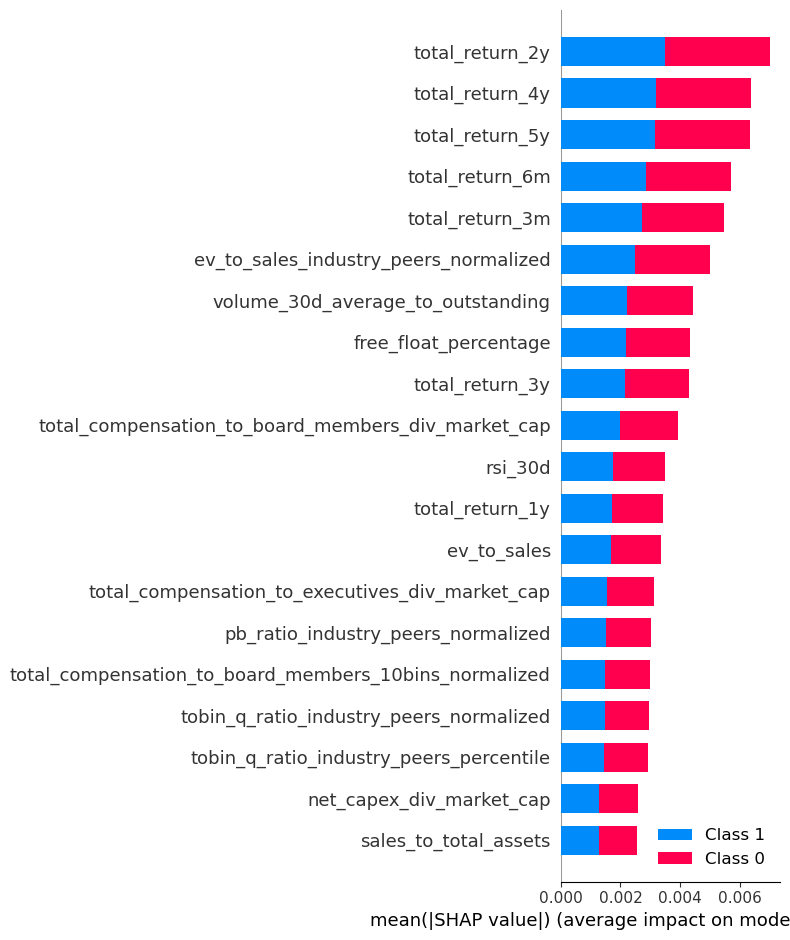

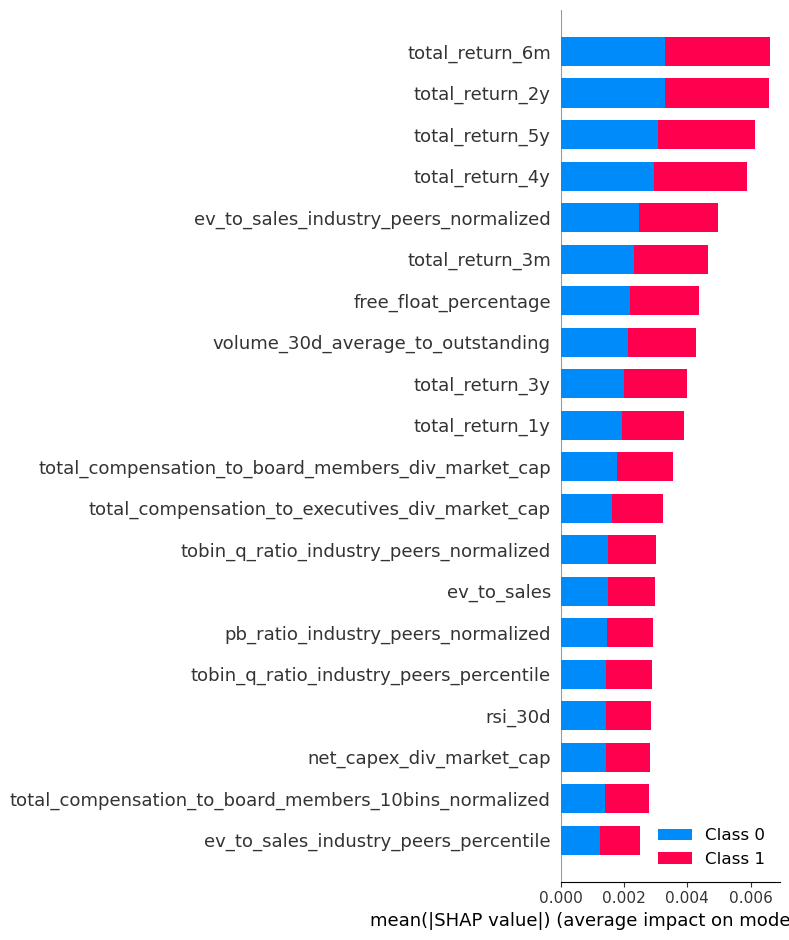

In [16]:
explainer = shap.Explainer(clf)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

shap.summary_plot(shap_values_train, X_train)
shap.summary_plot(shap_values_test, X_test)

## 3.3. Xgboost with bloomberg factors

In [17]:
bloomberg_factors = [
    "unequal_voting",
    "total_compensation_to_executives_10bins_percentile",
    "ceo_tenure",
    "ebitda_margin_industry_peers_percentile",
    "sales_to_total_assets_industry_peers_percentile",
    "institution_ownership_percentage",
    "volume_30d_average_to_outstanding",
    "free_float_percentage",
    "total_return_5y",
    "total_return_3y",
    "total_return_2y",
    "total_return_1y",
    "total_return_6m",
    "pb_ratio_industry_peers_percentile",
    "ev_to_sales_industry_peers_percentile",
    "ev_ebitda_industry_peers_percentile",
    "pe_ratio_industry_peers_percentile" 
]

In [18]:
train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[bloomberg_factors]
y_train = train_data['targeted']

X_test = test_data[bloomberg_factors]
y_test = test_data['targeted']

xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
y_pred_train = cross_val_predict(xgboost_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = xgboost_model.predict_proba(X_test)[:, 1]

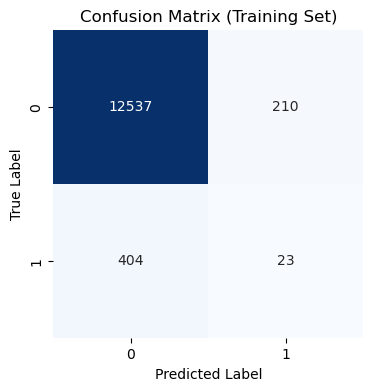

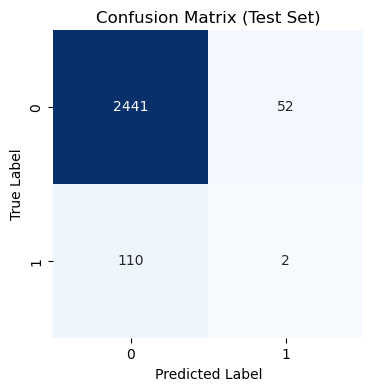

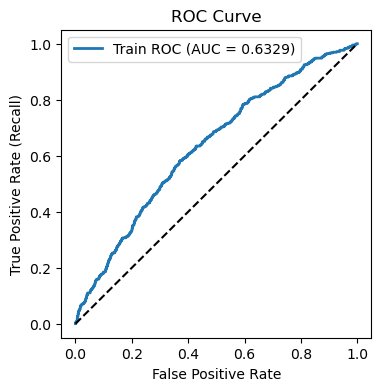

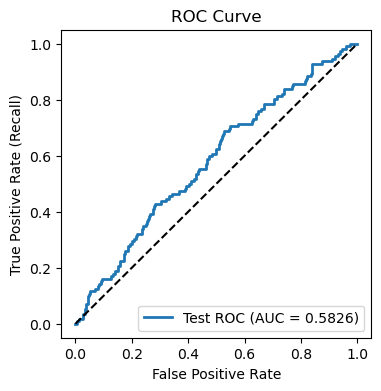

In [20]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.1)
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')

cm_test = confusion_matrix(y_test, y_pred_test > 0.1)
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


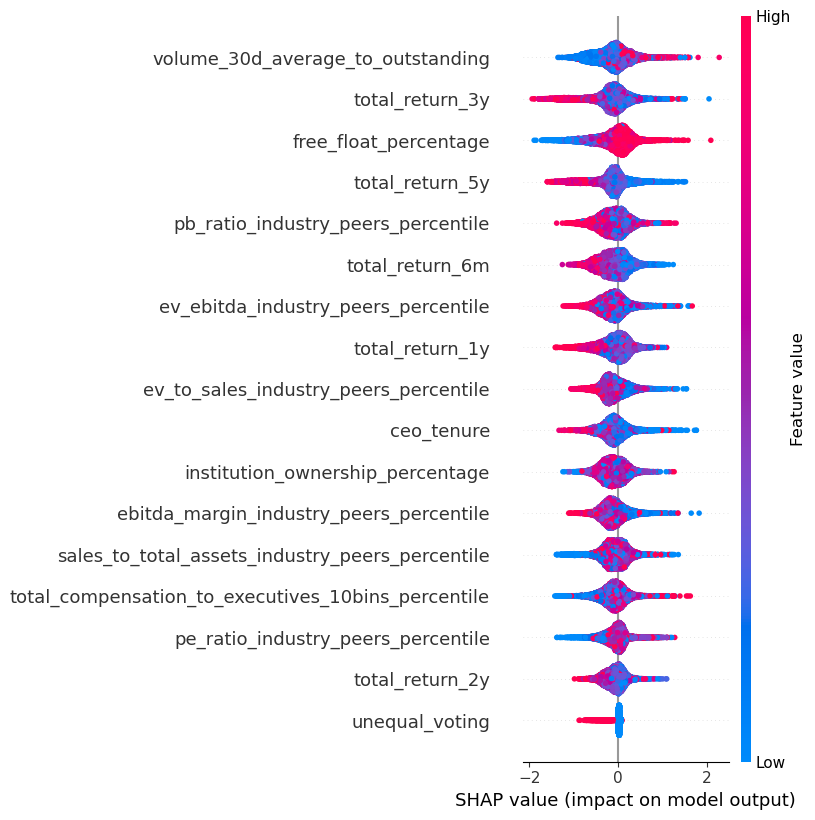

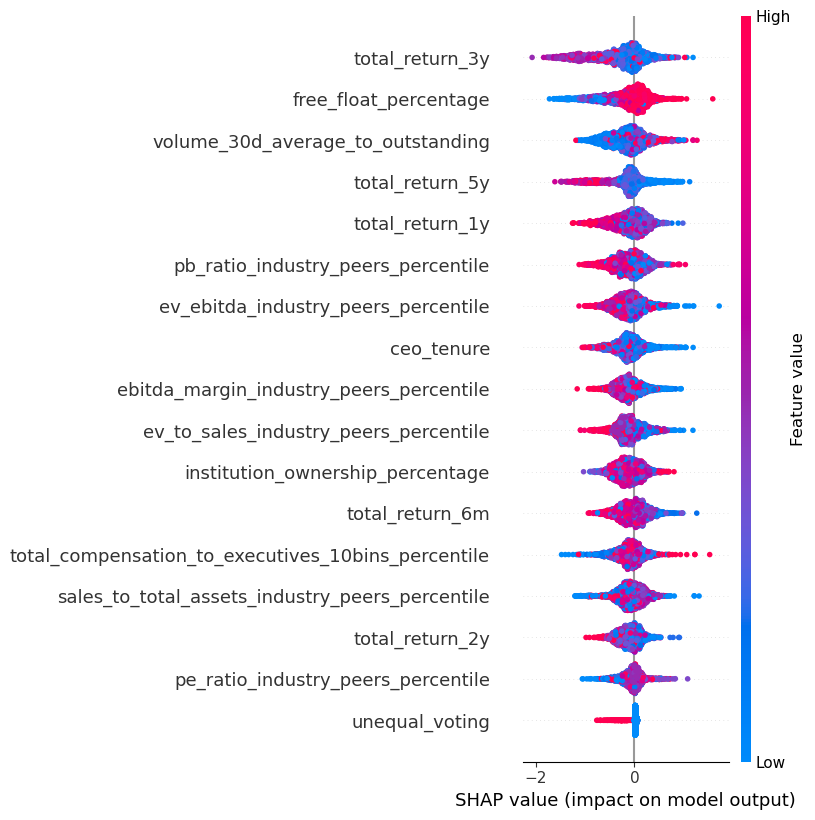

In [21]:
explainer = shap.Explainer(xgboost_model)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

shap.summary_plot(shap_values_train, X_train)
shap.summary_plot(shap_values_test, X_test)

## 3.4. Random forest with bloomberg factors

In [22]:
train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[bloomberg_factors]
y_train = train_data['targeted']

X_test = test_data[bloomberg_factors]
y_test = test_data['targeted']

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
y_pred_train = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = clf.predict_proba(X_test)[:, 1]

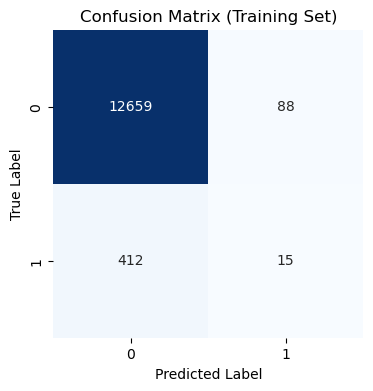

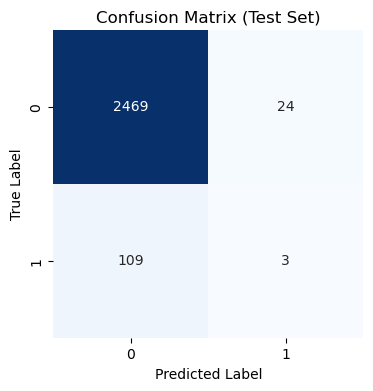

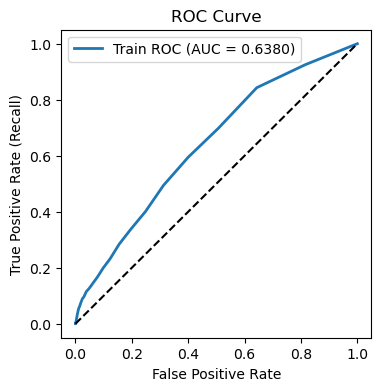

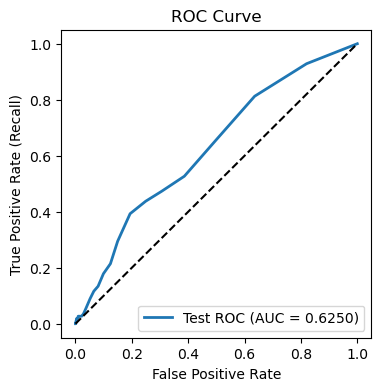

In [24]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.2)
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')

cm_test = confusion_matrix(y_test, y_pred_test > 0.2)
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()

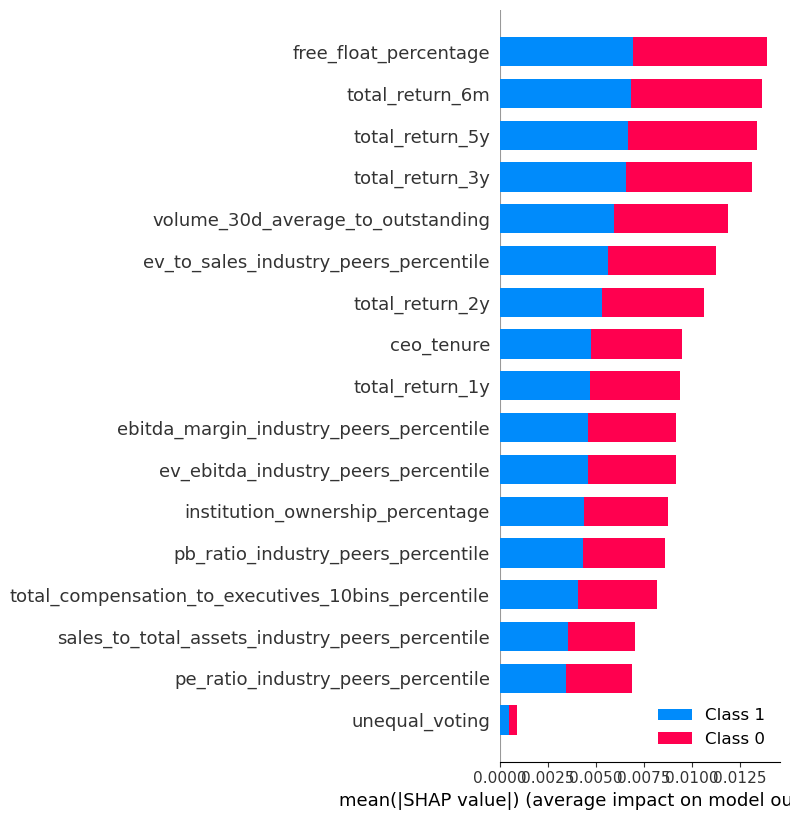

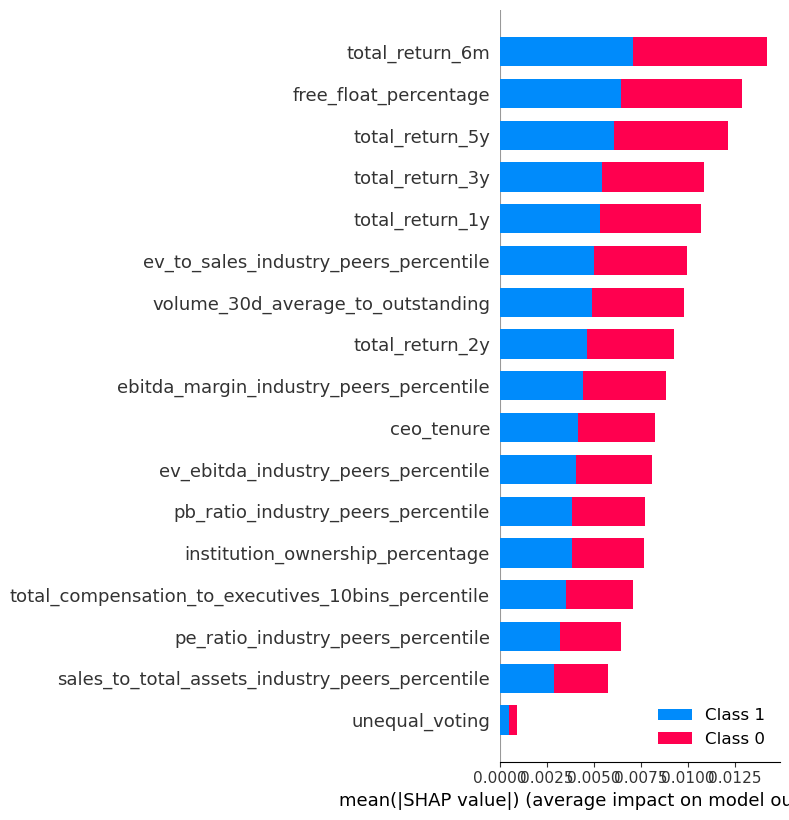

In [25]:
explainer = shap.Explainer(clf)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

shap.summary_plot(shap_values_train, X_train)
shap.summary_plot(shap_values_test, X_test)

## 3.5. Xgboost with all the columns after over-sampling with ADASYN

In [26]:
train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[factors]
y_train = train_data['targeted']

X_test = test_data[factors]
y_test = test_data['targeted']

adasyn = ADASYN(random_state=42)
X_train, y_train= adasyn.fit_resample(X_train, y_train)

xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [27]:
y_pred_train = cross_val_predict(xgboost_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = xgboost_model.predict_proba(X_test)[:, 1]

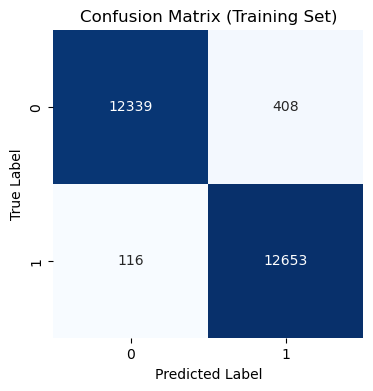

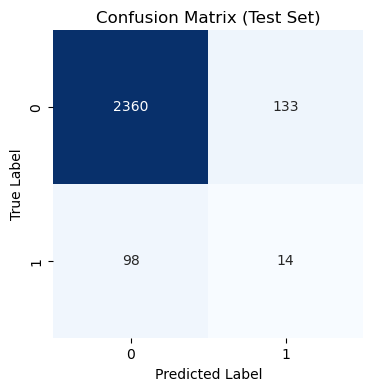

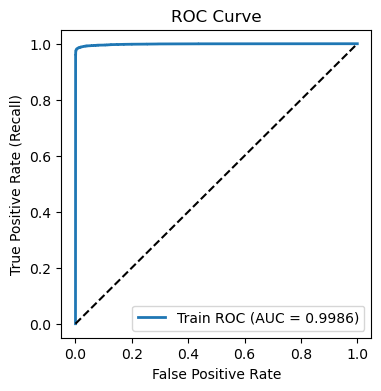

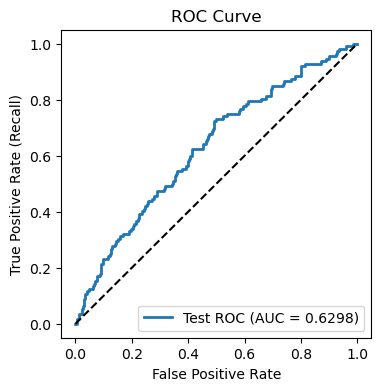

In [28]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.2)
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')

cm_test = confusion_matrix(y_test, y_pred_test > 0.2)
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


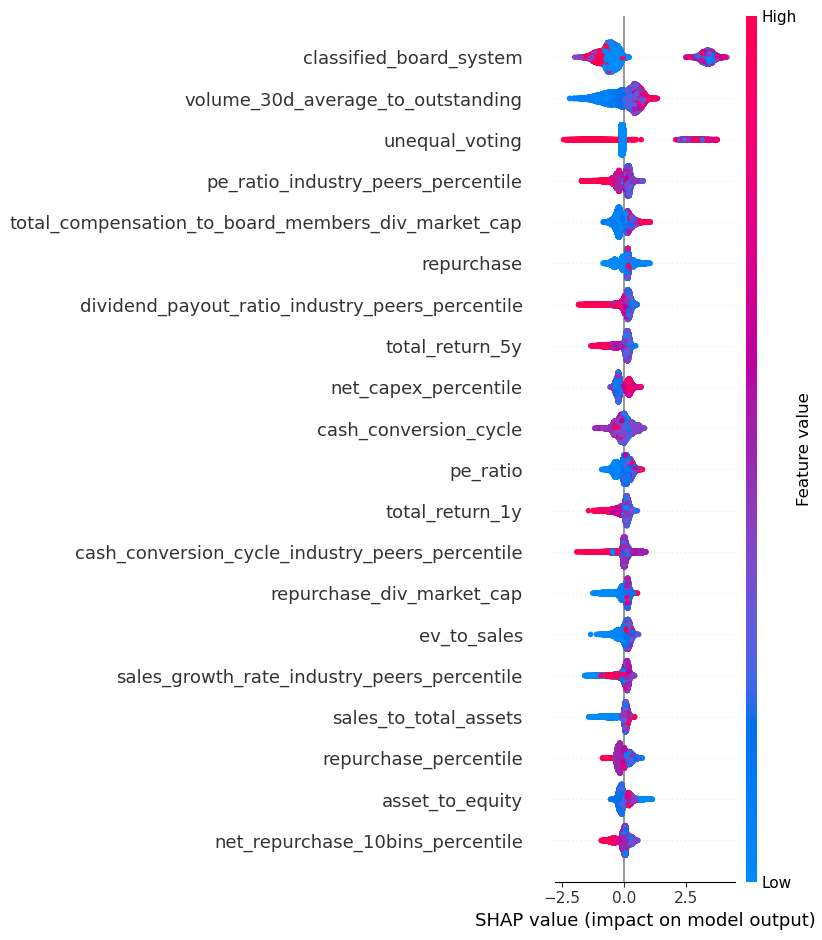

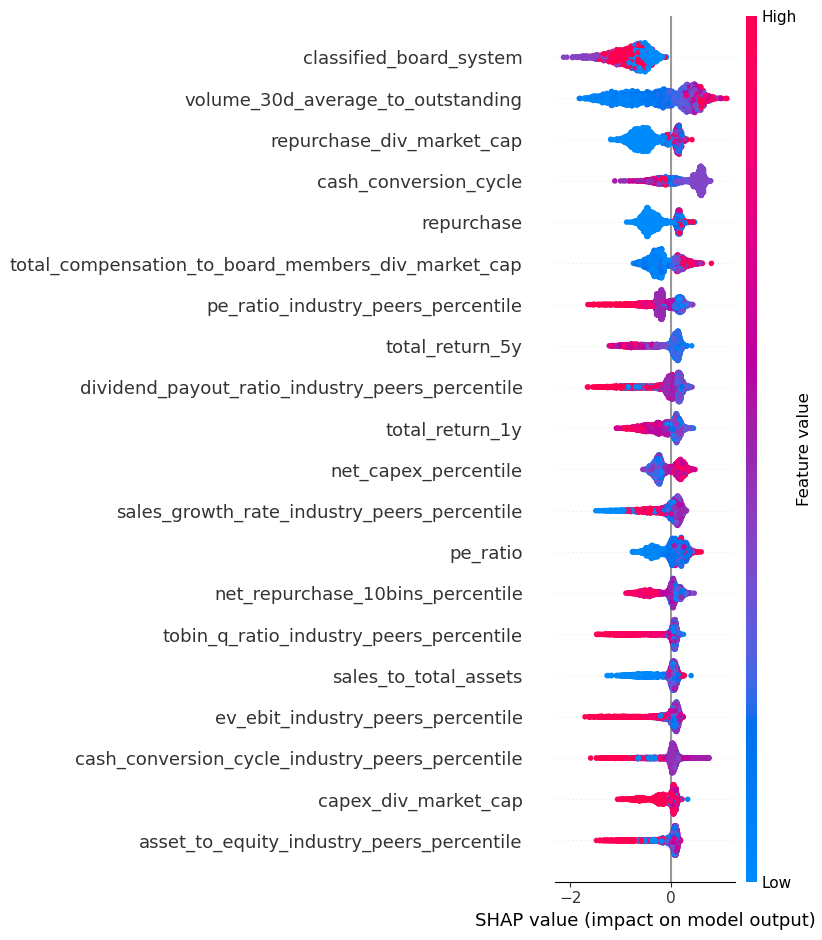

In [29]:
explainer = shap.Explainer(xgboost_model)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

shap.summary_plot(shap_values_train, X_train)
shap.summary_plot(shap_values_test, X_test)

## 3.6. Random Forest with all the columns after over-sampling with ADASYN

In [30]:
train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[factors]
y_train = train_data['targeted']

X_test = test_data[factors]
y_test = test_data['targeted']

adasyn = ADASYN(random_state=42)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [31]:
y_pred_train = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = clf.predict_proba(X_test)[:, 1]

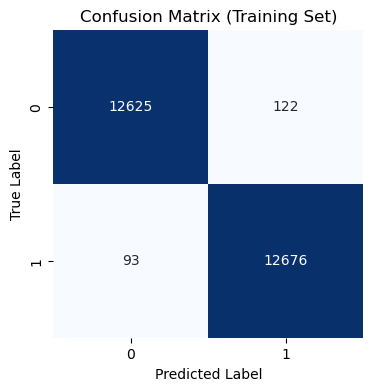

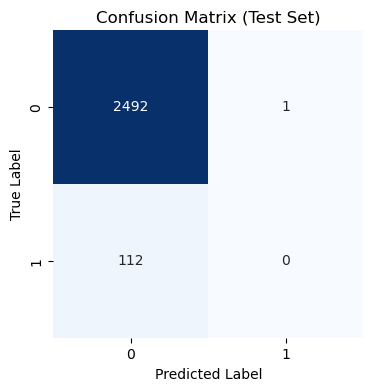

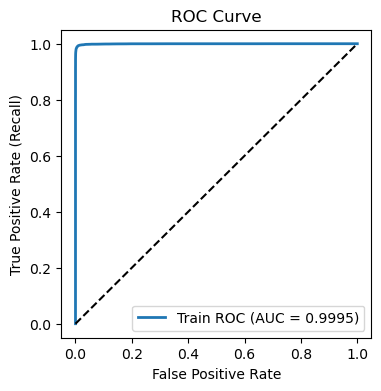

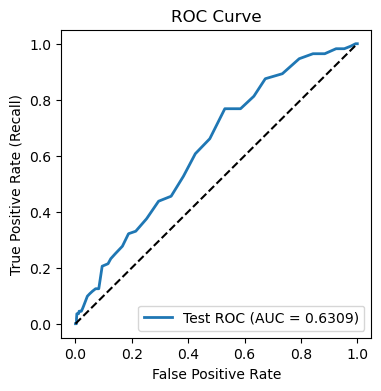

In [34]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.5)
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')

cm_test = confusion_matrix(y_test, y_pred_test > 0.5)
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# explainer = shap.Explainer(clf)
# shap_values_train = explainer.shap_values(X_train)
# shap_values_test = explainer.shap_values(X_test)

# shap.summary_plot(shap_values_train, X_train)
# shap.summary_plot(shap_values_test, X_test)

## 3.7. xgboost with Bloomberg factors after over-sampling with ADASYN

In [ ]:
train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[bloomberg_factors]
y_train = train_data['targeted']

X_test = test_data[bloomberg_factors]
y_test = test_data['targeted']

# ADASYN oversampling
adasyn = ADASYN(random_state=42)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

# Continue with your model training using the resampled data
xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
y_pred_train = cross_val_predict(xgboost_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = xgboost_model.predict_proba(X_test)[:, 1]

In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.2)
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')

cm_test = confusion_matrix(y_test, y_pred_test > 0.82)
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()

In [ ]:
explainer = shap.Explainer(xgboost_model)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

shap.summary_plot(shap_values_train, X_train)
shap.summary_plot(shap_values_test, X_test)

## 3.8 random forest with Bloomberg_factors after oversampling with ADASYN

In [ ]:
train_data = df[df['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df[df['year'] == 2021]

X_train = train_data[bloomberg_factors]
y_train = train_data['targeted']

X_test = test_data[bloomberg_factors]
y_test = test_data['targeted']

adasyn = ADASYN(random_state=42)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
y_pred_train = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = clf.predict_proba(X_test)[:, 1]

In [ ]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.5)
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')

cm_test = confusion_matrix(y_test, y_pred_test > 0.5)
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()

In [ ]:
explainer = shap.Explainer(clf)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

shap.summary_plot(shap_values_train, X_train)
shap.summary_plot(shap_values_test, X_test)

# 4. Summary

|                                                     | train AUC| test AUC|
|-----------------------------------------------------|----------|---------|
|Logistic Regression with all the rows                | 0.5287   | 0.5040  |
|Logistic Regression with rows with <=5 missing values| 0.5244   | 0.4647  |
|xgboost with all the columns                         | 0.6425   | 0.6638  | 
|random forest with all the columns                   | 0.6295   | 0.5680  |
|xgboost with Bloomberg Factors                       | 0.6329   | 0.5826  |
|random forest with Bloomberg Factors                 | 0.6380   | 0.6250  |
|xgboost with all the columns with ADASYN             | 0.9986   | 0.6298  |
|random forest with all the columns with ADASYN       | 0.9995   | 0.6309  |   

Logistic regression
- Test AUC close to 0.5, indicating the weak performances of the models

Xgboost
- Highest test AUC was achieved when all the factors and all the rows were used (0.6638). 
- Test AUC fell significantly when only Bloomberg's factors were used (0.5826).
- Over-sampling with ADASYN was not effective, as it returned the AUC of 0.6298.

Random Forest
- Random Forest model trained with all the rows and all the columns had the worst performance (0.5680)
- Test AUC rose significantly when only Bloomberg's factors were used (0.6250).
- ADASYN with all the columns rose AUC to 0.6309